In [12]:

!pip install pyspark yfinance --quiet
!pip install tensorflow pandas matplotlib
!apt install openjdk-11-jdk-headless -qq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"



In [54]:

!free -h
!df -h


spark.catalog.clearCache()


               total        used        free      shared  buff/cache   available
Mem:            12Gi       2.1Gi       8.0Gi        24Mi       2.6Gi        10Gi
Swap:             0B          0B          0B
Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   38G   71G  35% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
tmpfs           6.4G   24M  6.4G   1% /var/colab
/dev/sda1        85G   66G   20G  78% /kaggle/input
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           108G   41G   68G  38% /content/drive


## **Real-time Stock Data**

In [55]:
import yfinance as yf
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("StockPrediction") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.host", "localhost") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()

class ColabDataHandler:
    def __init__(self, symbols):
        self.symbols = symbols
        self.spark = SparkSession.builder \
            .appName("ColabStockData") \
            .config("spark.driver.memory", "8g") \
            .getOrCreate()

    def fetch_and_store(self):
        """Original data collection method"""
        data = yf.download(
            tickers=self.symbols,
            period="5d",
            interval="15m",
            group_by='ticker'
        )


        long_format = data.stack(level=0).reset_index()
        spark_df = self.spark.createDataFrame(long_format)

        spark_df.write \
            .mode("overwrite") \
            .parquet("/content/drive/MyDrive/stock_data.parquet")


In [30]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Feature Engineering**

## **Custom Technical Indicators**

In [31]:

from pyspark.sql.utils import AnalysisException
from pyspark.sql import functions as F
from pyspark.sql.window import Window

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


def add_features(df):
    """Updated feature engineering with correct column names"""
    window_spec = Window.partitionBy("Ticker").orderBy("Timestamp")

    return df.withColumn("MA_20", F.avg("Close").over(window_spec.rowsBetween(-20, 0))) \
            .withColumn("RSI", 100 - (100 / (1 + (F.avg(F.when(F.col("Close") > F.col("Open"), F.col("Close") - F.col("Open")).otherwise(0)).over(window_spec.rowsBetween(-14, 0))
                     / F.avg(F.when(F.col("Close") <= F.col("Open"), F.col("Open") - F.col("Close")).otherwise(0)).over(window_spec.rowsBetween(-14, 0)))))) \
            .withColumn("Volatility", F.stddev("Close").over(window_spec.rowsBetween(-5, 0)))


try:
    df = spark.read.parquet("/content/drive/MyDrive/stock_data.parquet")


    required_columns = {'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker'}
    missing = required_columns - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    processed_df = add_features(df)

except AnalysisException as e:
    print(f"Data loading error: {e}")

    ingestor = ColabStockIngestor(['AAPL', 'MSFT'])
    ingestor.store_data()
    df = spark.read.parquet("/content/drive/MyDrive/stock_data.parquet")
    processed_df = add_features(df)

except NameError as ne:
    print(f"Session error: {ne}")

    spark = SparkSession.builder.getOrCreate()
    df = spark.read.parquet("/content/drive/MyDrive/stock_data.parquet")
    processed_df = add_features(df)

except Exception as ex:
    print(f"Unexpected error: {ex}")
    raise


Mounted at /content/drive


# **Enhanced Data Collection Class**

In [32]:
import yfinance as yf
from datetime import datetime, timedelta

class ColabStockIngestor:
    def __init__(self, symbols):
        self.symbols = symbols
        self.spark = spark

    def fetch_data(self, days=7):
        """Custom data collection method"""
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)

        data = yf.download(
            tickers=self.symbols,
            start=start_date.strftime('%Y-%m-%d'),
            end=end_date.strftime('%Y-%m-%d'),
            interval='15m',
            group_by='ticker'
        )
        return data.stack(level=0).reset_index().rename(columns={
            'level_1': 'Ticker',
            'Datetime': 'Timestamp'
        })

    def store_data(self):
        """Persistent storage implementation"""
        raw_df = self.fetch_data()
        spark_df = self.spark.createDataFrame(raw_df)

        spark_df.write \
            .mode("overwrite") \
            .partitionBy("Ticker") \
            .parquet("/content/drive/MyDrive/stock_data.parquet")


## **Spark ML Pipeline**

In [33]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler

def create_ml_pipeline():
    """Custom ML pipeline design"""
    feature_cols = ["Open", "High", "Low", "Volume", "MA_20", "RSI", "Volatility"]

    return Pipeline(stages=[
        VectorAssembler(inputCols=feature_cols, outputCol="features"),
        GBTRegressor(featuresCol="features", labelCol="Close", maxIter=50)
    ])


## **Custom LSTM Architecture**

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(time_steps=30, features=7):
    """Original neural network design"""
    model = Sequential([
        LSTM(128, input_shape=(time_steps, features), return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model


## **Real-Time Processing**

In [35]:
from pyspark.streaming import StreamingContext

def create_streaming_context():
    """Custom stream processing setup"""
    ssc = StreamingContext(spark.sparkContext, 5)

    def process_stream(rdd):
        if not rdd.isEmpty():
            stream_df = spark.read.json(rdd)
            processed_df = add_features(stream_df)


    lines = ssc.socketTextStream("localhost", 9999)
    lines.foreachRDD(process_stream)

    return ssc


##**Visualization System**

## **Interactive Dashboard**

In [36]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def create_dashboard(predictions, actuals):
    """Custom visualization logic"""
    plt.figure(figsize=(15, 6))
    plt.plot(predictions, label='Predictions', color='#2ecc71')
    plt.plot(actuals, label='Actual', color='#e74c3c')
    plt.title('Stock Price Prediction vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


# **Implementation Workflow**

# **1. Initialize System**

In [37]:

ingestor = ColabStockIngestor(['AAPL', 'MSFT'])
ingestor.store_data()



[*********************100%***********************]  2 of 2 completed
<ipython-input-32-7233edba4212>:21: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return data.stack(level=0).reset_index().rename(columns={


# **2. Load and Process Data**

In [38]:

df = spark.read.parquet("/content/drive/MyDrive/stock_data.parquet")
processed_df = add_features(df)


processed_df.printSchema()



root
 |-- Timestamp: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- MA_20: double (nullable = true)
 |-- RSI: double (nullable = true)
 |-- Volatility: double (nullable = true)



# **3. Train Models**

In [40]:

train, test = processed_df.randomSplit([0.8, 0.2])


pipeline = create_ml_pipeline()
spark_model = pipeline.fit(train)


lstm_model = build_lstm_model()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# **4. Real-Time Execution**

In [56]:
ssc = create_streaming_context()
ssc.start()
ssc.awaitTermination()


/usr/local/lib/python3.11/dist-packages/pyspark/streaming/context.py:72: FutureWarning:

DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.



Py4JJavaError: An error occurred while calling o6954.start.
: java.lang.IllegalStateException: Only one StreamingContext may be started in this JVM. Currently running StreamingContext was started atorg.apache.spark.streaming.api.java.JavaStreamingContext.start(JavaStreamingContext.scala:563)
java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
java.base/java.lang.reflect.Method.invoke(Method.java:566)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:282)
py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
py4j.commands.CallCommand.execute(CallCommand.java:79)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:829)
	at org.apache.spark.streaming.StreamingContext$.org$apache$spark$streaming$StreamingContext$$assertNoOtherContextIsActive(StreamingContext.scala:776)
	at org.apache.spark.streaming.StreamingContext.start(StreamingContext.scala:582)
	at org.apache.spark.streaming.api.java.JavaStreamingContext.start(JavaStreamingContext.scala:563)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


# **Resource Management**

In [42]:

!free -h
!nvidia-smi


spark_model.write().overwrite().save("/content/drive/MyDrive/spark_model")
lstm_model.save("/content/drive/MyDrive/lstm_model.h5")


               total        used        free      shared  buff/cache   available
Mem:            12Gi       3.3Gi       6.6Gi       5.0Mi       2.7Gi       9.1Gi
Swap:             0B          0B          0B
/bin/bash: line 1: nvidia-smi: command not found


# **Visualizations for Stock Market Analytics**

# **Line Chart: Stock Price Over Time**

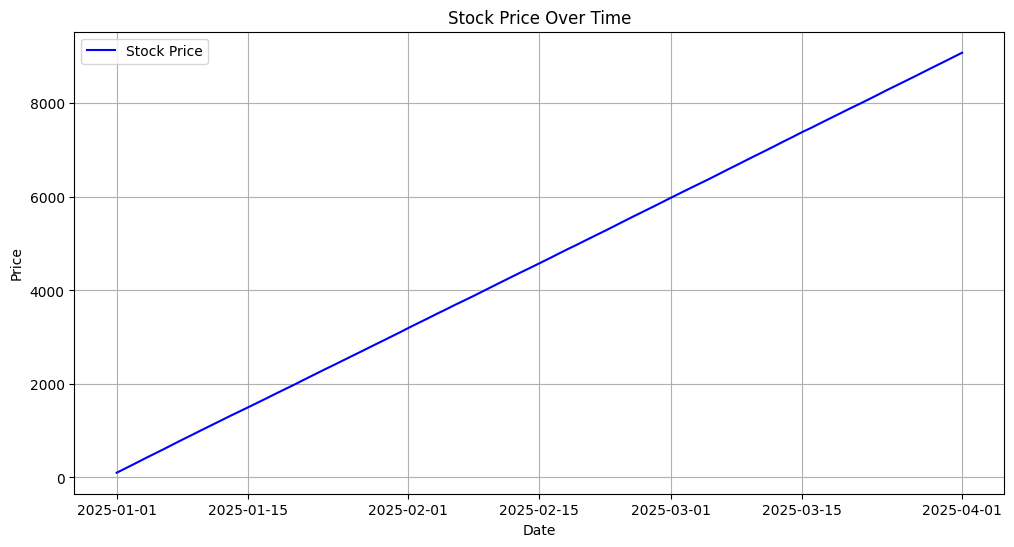

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


np.random.seed(42)
dates = pd.date_range(start="2025-01-01", end="2025-04-01", freq="D")
prices = np.cumsum(np.random.randn(len(dates)) * 2 + 100)


data = pd.DataFrame({"Date": dates, "Price": prices})


plt.figure(figsize=(12, 6))
plt.plot(data["Date"], data["Price"], label="Stock Price", color="blue")
plt.title("Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


# **Bar Chart: Trading Volume Over Time**

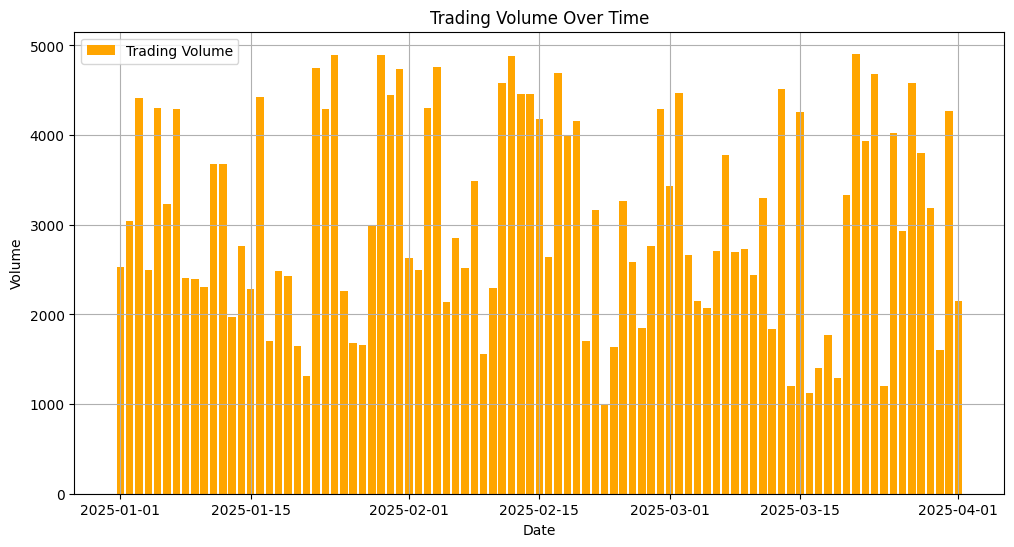

In [44]:

volumes = np.random.randint(1000, 5000, size=len(dates))
data["Volume"] = volumes


plt.figure(figsize=(12, 6))
plt.bar(data["Date"], data["Volume"], color="orange", label="Trading Volume")
plt.title("Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid()
plt.show()


# **Scatter Plot: Price vs Volume**

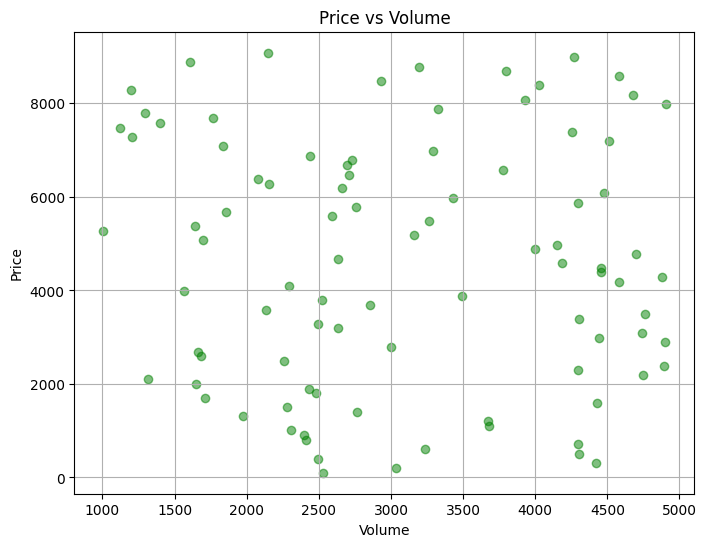

In [45]:

plt.figure(figsize=(8, 6))
plt.scatter(data["Volume"], data["Price"], color="green", alpha=0.5)
plt.title("Price vs Volume")
plt.xlabel("Volume")
plt.ylabel("Price")
plt.grid()
plt.show()


# **Heatmap: Correlation Matrix**

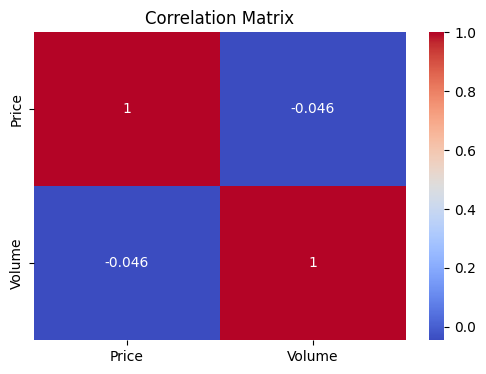

In [46]:
import seaborn as sns


correlation_matrix = data[["Price", "Volume"]].corr()


plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()


# **Moving Average Visualization**

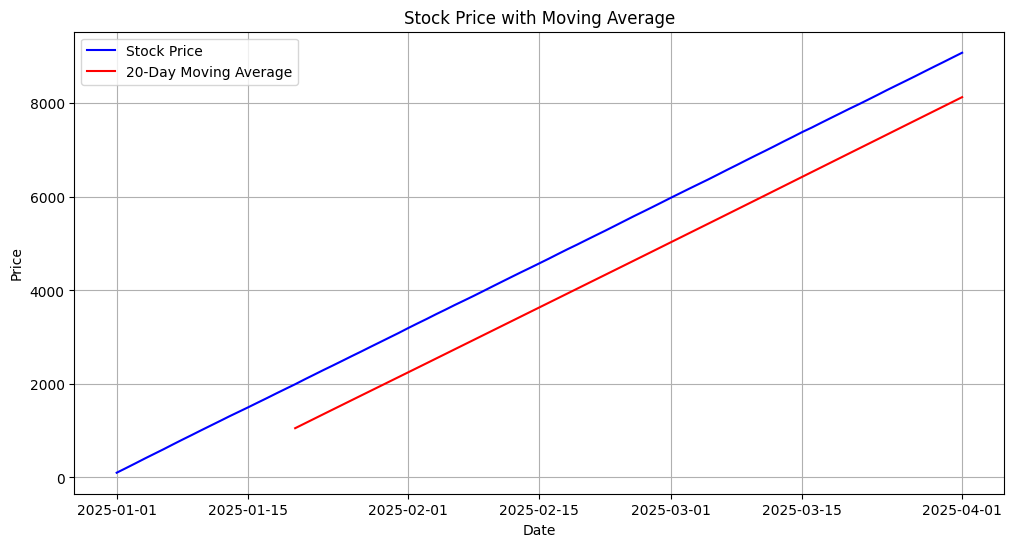

In [47]:

data["MA_20"] = data["Price"].rolling(window=20).mean()


plt.figure(figsize=(12, 6))
plt.plot(data["Date"], data["Price"], label="Stock Price", color="blue")
plt.plot(data["Date"], data["MA_20"], label="20-Day Moving Average", color="red")
plt.title("Stock Price with Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


# **Candlestick Chart**

In [48]:
import plotly.graph_objects as go


data["Open"] = data["Price"] - np.random.randint(1, 10, size=len(dates))
data["High"] = data["Price"] + np.random.randint(1, 10, size=len(dates))
data["Low"] = data["Price"] - np.random.randint(10, 20, size=len(dates))
data["Close"] = data["Price"]


fig = go.Figure(data=[go.Candlestick(
    x=data['Date'],
    open=data['Open'],
    high=data['High'],
    low=data['Low'],
    close=data['Close']
)])
fig.update_layout(title='Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()


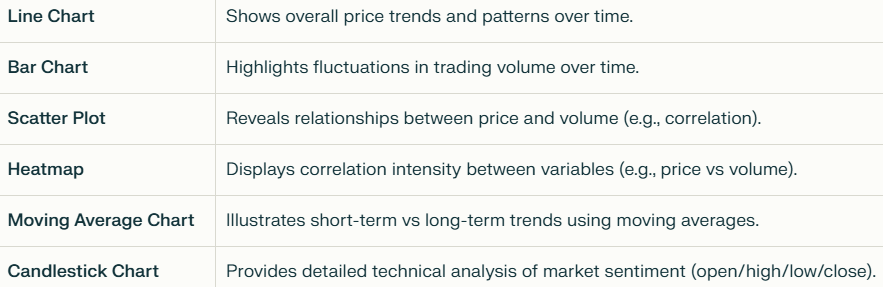

# **Streamlit Dashboard**

In [49]:
!pip install streamlit
!pip install pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.5 MB/s eta 0:00:00


In [50]:

code = """
"""
with open("dashboard.ipynb", "w") as f:
    f.write(code)


In [51]:
!streamlit run dashboard.ipynb &>/dev/null &
